In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [3]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-04-22 22:46:18.656776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745383578.666837 2549948 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745383578.669916 2549948 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745383578.678522 2549948 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745383578.678533 2549948 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745383578.678534 2549948 computation_placer.cc:177] computation placer alr

### Data Analysis

In [4]:
df = pd.read_csv('/home/alvaro/tf_templates/DATA/daily_climate.csv', index_col='date', parse_dates=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
df = df[['meantemp']]

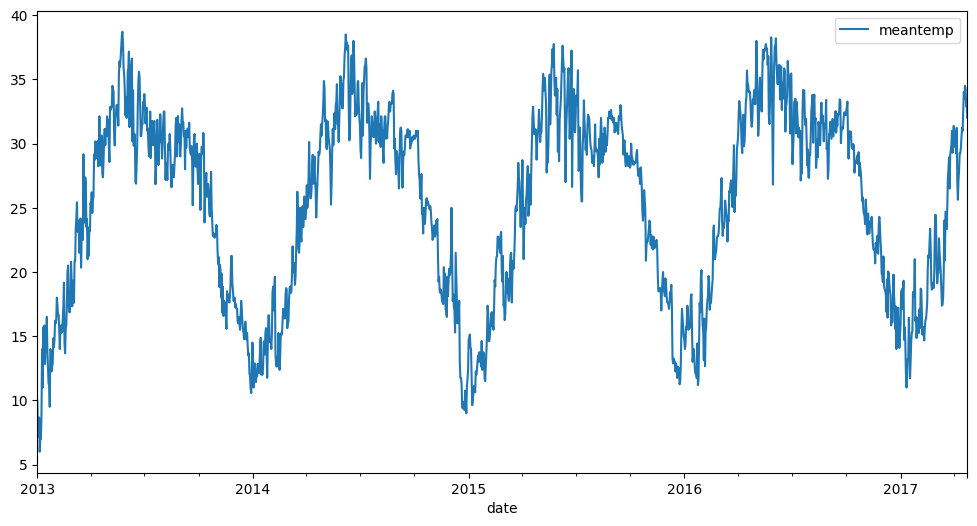

In [6]:
df.plot(figsize=(12,6));

### Train Test Split

In [7]:
test_percentage = 0.3
test_size = int(len(df) * test_percentage)
test_ind = len(df) - test_size

In [8]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scale Data

In [9]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

### Time Series Generator

In [10]:
length = 365
batch_size = 32
n_features = 1

In [11]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

### Model Training

In [12]:
model = Sequential([
    Input(shape=(length, n_features)),
    LSTM(units=512, activation='relu'),
    Dense(units=1)
])

I0000 00:00:1745383589.923011 2549948 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


In [13]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [14]:
early_stop = EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True)

In [15]:
model.fit(generator, epochs=200, validation_data=validation_generator, batch_size=batch_size, callbacks=[early_stop])

Epoch 1/200


/home/alvaro/tf_templates/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745383596.729471 2550119 service.cc:152] XLA service 0x3b931440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745383596.729502 2550119 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2025-04-22 22:46:36.750247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745383596.868621 2550119 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-22 22:46:37.651195: I external/loc

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.1394 - mae: 0.2623 - val_loss: 0.0102 - val_mae: 0.0857
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0127 - mae: 0.0917 - val_loss: 0.0144 - val_mae: 0.0954
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0115 - mae: 0.0905 - val_loss: 0.0095 - val_mae: 0.0797
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0060 - mae: 0.0616 - val_loss: 0.0063 - val_mae: 0.0670
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0053 - mae: 0.0576 - val_loss: 0.0072 - val_mae: 0.0700
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0089 - mae: 0.0773 - val_loss: 0.0072 - val_mae: 0.0713
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0054 - mae: 0.0566 - val_loss: 0.0078 - val_mae: 0.0726
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0052 - mae: 0.0582 - val_loss: 0.0058 - val_mae: 0.0650
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0042 

### Evaluation

In [16]:
history = pd.DataFrame(model.history.history)

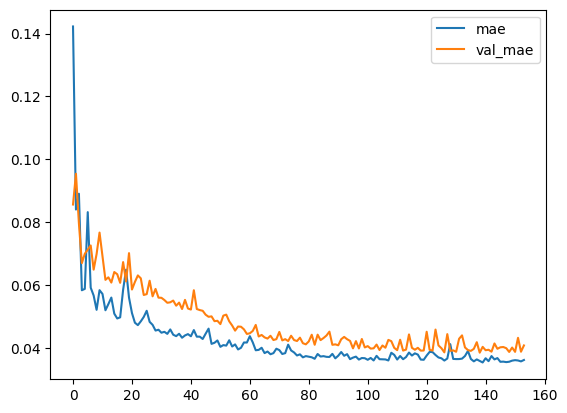

In [17]:
history[['mae', 'val_mae']].plot();

In [18]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_prediction = model.predict(current_batch, verbose=0)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

In [20]:
predictions = scaler.inverse_transform(test_predictions)
test.loc[:, 'Predictions'] = predictions

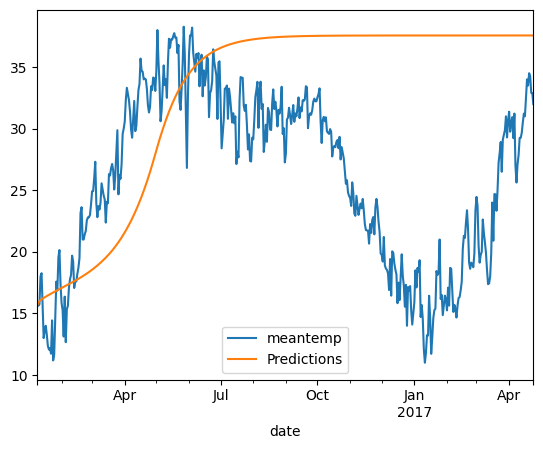

In [21]:
test.plot();

In [22]:
y_test = test['meantemp'].values

mean_absolute_error(y_test, predictions)

9.367629120793689

In [23]:
np.sqrt(mean_squared_error(y_test, predictions))

np.float64(11.521085813002555)

In [24]:
explained_variance_score(y_test, predictions)

-0.7451349262137938

### Forecasting

In [25]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [26]:
forecast = []
periods = 90
first_eval_batch = scaled_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_prediction = model.predict(current_batch, verbose=0)[0]
    forecast.append(current_prediction)
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

In [27]:
forecast = scaler.inverse_transform(forecast)

In [28]:
forecast

array([[32.4516193 ],
       [32.89536336],
       [33.20611485],
       [33.42275524],
       [33.59648951],
       [33.7495    ],
       [33.89066665],
       [34.02377622],
       [34.15066164],
       [34.27234855],
       [34.38946875],
       [34.50244341],
       [34.61156112],
       [34.71703248],
       [34.81900567],
       [34.9176055 ],
       [35.01292555],
       [35.10505553],
       [35.19406953],
       [35.28005336],
       [35.36307719],
       [35.44321904],
       [35.52056081],
       [35.59518827],
       [35.66717944],
       [35.73661622],
       [35.80357658],
       [35.86813465],
       [35.9303723 ],
       [35.99035975],
       [36.04817497],
       [36.10388818],
       [36.15757347],
       [36.20930104],
       [36.25914888],
       [36.3071872 ],
       [36.35347838],
       [36.39808872],
       [36.44107673],
       [36.48249701],
       [36.52240804],
       [36.56086053],
       [36.59790907],
       [36.63360047],
       [36.66798542],
       [36

In [29]:
df

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000
...,...
2017-04-20,34.500000
2017-04-21,34.250000
2017-04-22,32.900000


In [30]:
forecast_index = pd.date_range(start='2017-04-24', periods=periods, freq='D')

In [31]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

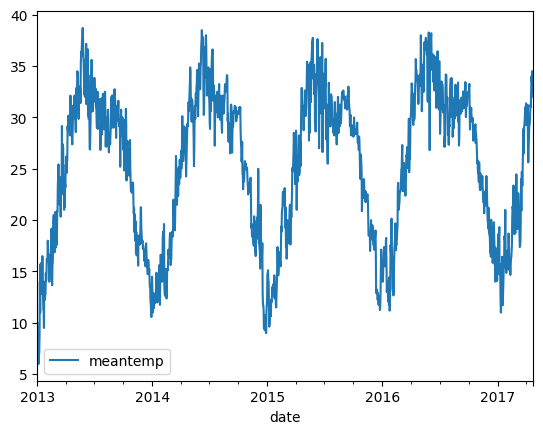

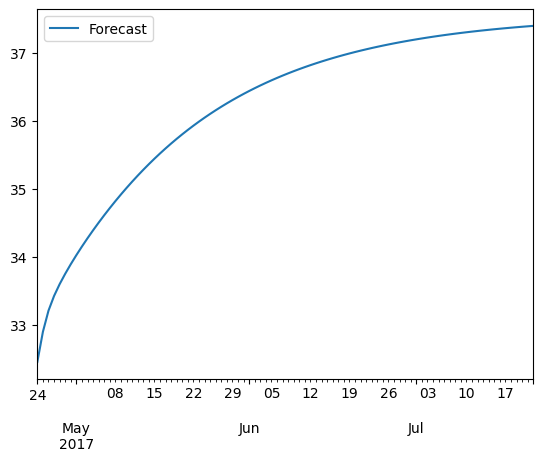

In [32]:
df.plot()
forecast_df.plot();

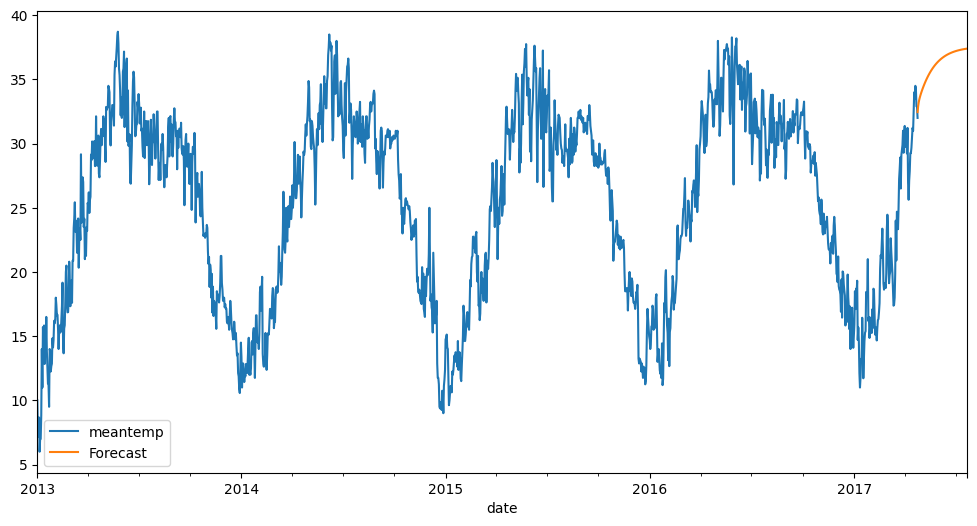

In [33]:
forecast_df.plot(ax=df.plot(), figsize=(12,6));